In [1]:
import math
import matplotlib.pyplot as plt
!pip install graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

In [4]:
import random

class Neuron:
    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum(wi*xi for wi, xi in zip(self.w, x))
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

 ### O Nosso Notebook começa aqui o codígo acima são apenas algumas dependências.

 ### 1 - Vamos entender o Value (Scalar)

In [5]:
#from bitgrad.engine import Value

In [6]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label='c'

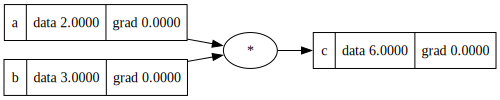

In [7]:
draw_dot(c)

In [8]:
c.backward()

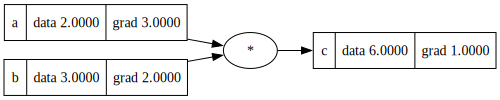

In [9]:
draw_dot(c)

Como demonstrado acima o nosso objeto `Value` possui a implementação das operações aritimeticas elementares e armazena os `Values` usados nas operações criando uma DAG.

Vimos tambem a chamada do `.backward()` para calcular o gradiente de `a` e `b` ou seja o quanto `a` e `b` influencia o nosso output `c`.

estamos multiplicando `a` * `b` então de maneira intutiva conseguims entender que o gradiente de `a` é igual a `b` e o gradiente de `b` é igual a `a`.

In [10]:
## Vamos criar uma rede neural utilizando nossa bibloteca + engine

In [11]:
x = [1, 0]
n = MLP(2, [4, 1])

In [12]:
n(x)

Value(data=0.8741757208656696, grad=0.0)

Acima inicializamos a nossa rede neural com: 

3 Camadas, 2 Neuronios na camada de entrada, 4 neuronios na camada oculta e 1 neuronio na camada de saida.

algo como a imagem abaixo:

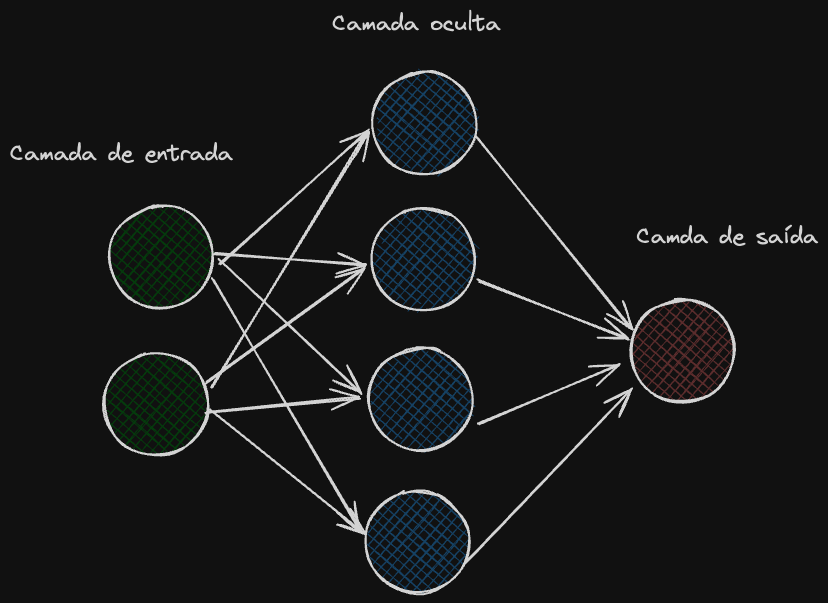

### Vamos treinar nossa rede neural para resolver o portão XOR

In [13]:
xs = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
] # Dados de inputs
ys = [0, 1, 1, 0] # Dados de outputs|

loss_values = []
k_values = []

Acima estamos passando nossos dados de inputs e nossos dados de outputs para treinar a rede neural

Vamos criar o nosso looping de treinamento

In [14]:
for k in range(2000):
    # Forward Pass
    ypred = [n(x) for x in xs] 
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)) # Loss function

    # Backwward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()    

    # Update
    
    for p in n.parameters():
        p.data += -0.01 * p.grad


    k_values.append(k)
    loss_values.append(loss.data)

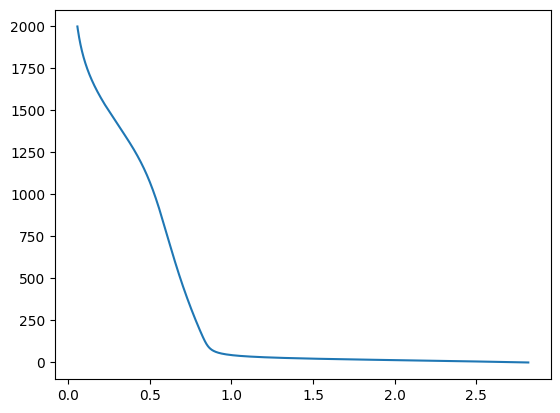

In [15]:
plt.plot(loss_values, k_values)
plt.show()

Acima conseguimos ver a evolução da nossa rede neural a taxa de loss caindo de acordo com o aumento de iterações.

In [16]:
ypred

[Value(data=0.0, grad=0.0),
 Value(data=0.8345154410502512, grad=-0.33096911789949757),
 Value(data=0.8412187809151551, grad=-0.31756243816968976),
 Value(data=0.06729966787006642, grad=0.13459933574013283)]

### Depois de treinar nossa rede neural vamos testar

In [17]:
# Test the network
for x in xs:
    y_pred = n(x)
    print(f'Entrada:{x}, Resultado: {y_pred.data:.2f}')

Entrada:[0, 0], Resultado: 0.00
Entrada:[0, 1], Resultado: 0.83
Entrada:[1, 0], Resultado: 0.84
Entrada:[1, 1], Resultado: 0.07
